# Beat-Upbeat Ratio Distributions

## Import dependencies, set constants etc.

In [139]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from src import utils
import src.visualise.visualise_utils as vutils
from src.features.features_utils import FeatureExtractor

In [23]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
N_BOOT = 999

In [24]:
# Upper and lower bounds to use when thresholding BURs
BUR_UPPER = 4.0
BUR_LOWER = 0.25

In [25]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in the data we extracted from our `corpus_chronology` in `src\features\extract_features.py`. This gives us a list of `FeatureExtractor` classes (defined in `src\features\features_utils.py`).

In [26]:
features: list[FeatureExtractor] = utils.unserialise_object(fr'{utils.get_project_root()}\models\extracted_features_corpus_chronology')

In [27]:
res = []
# Iterate through each track
for track in features:
    # Iterate through each instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Iterate through each BUR by that instrument
        for bur in track.BURs[instr].bur['burs'].dropna().to_list():
            # Append a new dictionary
            res.append(dict(musician=track.metadata[instr]['performer'], bur=bur, instrument=instr))
burs = pd.DataFrame(res)

## Clean data
We drop BUR values lower than 0.25 and higher than 4 (see Corcoran & Frieler, 2021)

In [37]:
burs = burs[(burs['bur'] > BUR_LOWER) & (burs['bur'] < BUR_UPPER)]

## Compute the KDE and extract peaks

In [146]:
def get_peaks(data, len_data: int = 1000, **kwargs) -> np.ndarray:
    """Extract peaks from a fitted kernel-density estimate"""
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    kde = stats.gaussian_kde(data.T)
    kde_eval = kde.evaluate(data_plot.T)
    peaks, _ = signal.find_peaks(kde_eval, **kwargs)
    return np.sort(data_plot[peaks].flatten())

def bootstrap_peaks(data: np.array, actual_peaks: np.array, tol: float = 0.5):
    boot_res = {pe: [] for pe in actual_peaks}
    size = len(data)
    data = data.flatten()
    for i_ in range(10):
        print(i_)
        np.random.seed(i_)
        boot = np.random.choice(data, replace=True, size=size).reshape(-1, 1)
        boot_peaks = set(get_peaks(boot))
        for peak in actual_peaks:
            try:
                closest_peak = min(boot_peaks, key=lambda x: abs(x - peak))
            except ValueError:
                break
            else:
                if abs(closest_peak - peak) > tol:
                    continue
                else:
                    boot_res[peak].append(closest_peak)
                    boot_peaks.remove(closest_peak)
    return {k: [np.percentile(v, 5), np.percentile(v, 95)] for k, v in boot_res.items()}


In [ ]:
res_ = []
for instr, grp in burs.groupby('instrument'):
    X = grp['bur'].to_numpy().reshape(-1, 1)
    grp_peaks = get_peaks(X)
    ci_peaks = bootstrap_peaks(X, grp_peaks)
    for num, (actual, (low, high)) in enumerate(ci_peaks.items()):
        res_.append(dict(
            instrument=instr,
            peak_num=num,
            peak=actual,
            low=low,
            high=high
        ))
print(res_)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


## Determine the optimal number of components for the GMM

In [54]:
def gmm_bic_score(estimator, x):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(x)

In [170]:
opt_res = []
for instr, vals in burs.groupby('instrument'):
    grid_search = GridSearchCV(
        GaussianMixture(
            random_state=SEED,
            covariance_type='full',
            init_params='k-means++'
        ),
        param_grid=dict(
            n_components=range(1, 4)
        ),
        scoring=gmm_bic_score,
        cv=N_FOLDS,
        n_jobs=N_JOBS,
    )
    grid_search.fit(vals['bur'].to_numpy().reshape(-1, 1))
    df = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "mean_test_score"]]
    df["mean_test_score"] = -df["mean_test_score"]
    df['instrument'] = instr
    opt_res.append(df)
opt_res = pd.concat(opt_res).set_index('instrument').loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()].reset_index(drop=False)
opt_res.head()

,instrument,param_n_components,mean_test_score
0,piano,1,13219.765830
1,piano,2,12379.161553
2,piano,3,12347.142714
3,bass,1,4441.632431
4,bass,2,3805.244994


## Plot the average BIC score for each number of components

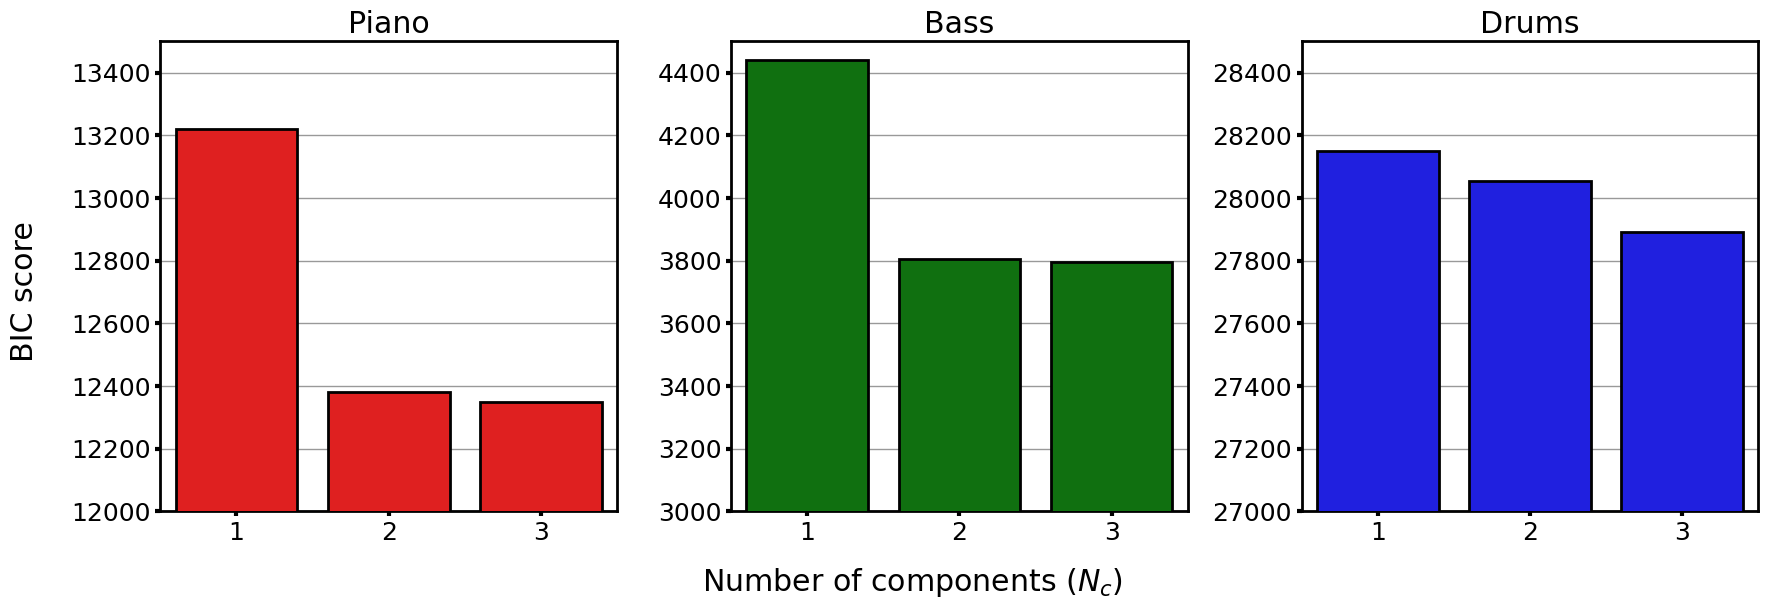

In [171]:
class BarPlotBURNComponentsBIC(vutils.BasePlot):
    # These are the keywords we apply to all bar plots
    bar_kws = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=None,
        lw=vutils.LINEWIDTH, seed=SEED, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, zorder=3, estimator=np.mean,
    )
    lims = [(12000, 13500), (3000, 4500), (27000, 28500)]

    def __init__(self, results: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'bur_plots\barplot_ncomponents_bic_{self.corpus_title}', **kwargs)
        self.df = results
        self.fig, self.ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(vutils.WIDTH, vutils.WIDTH / 3))

    def _create_plot(self):
        for ax, (idx, grp), col in zip(self.ax.flatten(), self.df.groupby('instrument', sort=False), vutils.RGB):
            g = sns.barplot(data=grp, x='param_n_components', y='mean_test_score', color=col, ax=ax, **self.bar_kws)
            g.set_title(idx.title())

    def _format_ax(self):
        for ax, lim in zip(self.ax.flatten(), self.lims):
            # Set the width of the edges and ticks
            plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
            ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
            # Add a vertical grid
            ax.grid(zorder=0, axis='y', **vutils.GRID_KWS)
            ax.set(ylim=lim, xlabel='', ylabel='')

    def _format_fig(self):
        self.fig.supxlabel('Number of components ($N_c$)')
        self.fig.supylabel('BIC score')
        self.fig.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.95, wspace=0.25)

BarPlotBURNComponentsBIC(opt_res).create_plot()
plt.show()

The graph shows that 2 components performs best for piano and bass, and 3 components best for drums

In [67]:
best_components = {'piano': 2, 'bass': 2, 'drums': 3}

## Fit the optimized models, get means, weights, and confidence intervals
Now that we know the optimal number of components for each instrument, we can fit the optimized models and extract the mean and weight of each component.

In [163]:
def bootstrap(val, ins: str) -> dict:
    """Obtain bootstrapped 95% confidence intervals for the mean of each component in a GMM"""
    # Get the required number of components for this instrument
    n_comp = best_components[ins]
    # Create an empty dictionary of lists to store our means in
    means = {n: [] for n in range(n_comp)}
    # Iterate over each required bootstrap sample
    for i_ in range(N_BOOT):
        print(i_)
        # Create the optimized GMM using the required number of components
        gm_b = GaussianMixture(
            random_state=SEED,
            covariance_type='full',
            n_components=n_comp,
            init_params='k-means++'
        )
        # Obtain a random sample of our data, with replacement, and reshape to correct format
        x_ = val.sample(frac=1, replace=True, random_state=i_).to_numpy().reshape(-1, 1)
        # Fit the GMM to our sampled data
        gm_b.fit(x_)
        # Sort our means, then iterate through and append to the list in our dictionary
        for i__, mean in enumerate(np.sort(gm_b.means_.flatten())):
            means[i__].append(mean)
    # Return a dictionary, with keys equivalent to component number and values a list of lower and upper bounds
    return {k: [np.percentile(v, 5), np.percentile(v, 95)] for k, v in means.items()}

In [164]:
means_weights = []
# Iterate through each instrument in our trio
for instr, vals in burs.groupby('instrument', sort=False):
    # Get the actual data, in the correct format
    X = vals['bur'].to_numpy().reshape(-1, 1)
    # Create the optimized GMM and fit to the data
    gm = GaussianMixture(
        random_state=SEED,
        covariance_type='full',
        n_components=best_components[instr],
        init_params='k-means++'
    )
    gm.fit(X)
    # Get the true mean and weight
    true_means, true_weights = gm.means_.flatten(), gm.weights_.flatten()
    # Get the indexes required to sort the true means and weights, then sort
    idx = np.argsort(true_means)
    true_means, true_weights = true_means[idx], true_weights[idx]
    # Get our bootstrapped confidence intervals for the mean of each component (these are already sorted)
    boot_means = bootstrap(vals['bur'], instr)
    # Iterate through each component
    for i in range(len(idx)):
        # Append the results for this component to the dictionary
        means_weights.append(dict(
            instr=instr,
            component=i,
            low=boot_means[i][0],
            mean=true_means[i],
            high=boot_means[i][1],
            weight=true_weights[i]
        ))
# Create the dataframe: no need to sort, as should already be in the right order
comp_df = pd.DataFrame(means_weights)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [172]:
comp_df

,instr,component,low,mean,high,weight
0,piano,0,1.010602,1.043076,1.202289,0.556116
1,piano,1,1.538123,1.693530,2.435968,0.443884
2,bass,0,0.748196,0.804415,0.814692,0.655661
3,bass,1,1.805803,2.071821,2.096494,0.344339
4,drums,0,0.527740,0.590285,1.246279,0.129598
5,drums,1,1.475132,1.547429,2.247887,0.382524
6,drums,2,2.373271,2.448782,3.189643,0.487878


## Plot the BUR distribution with density curve and GMM means

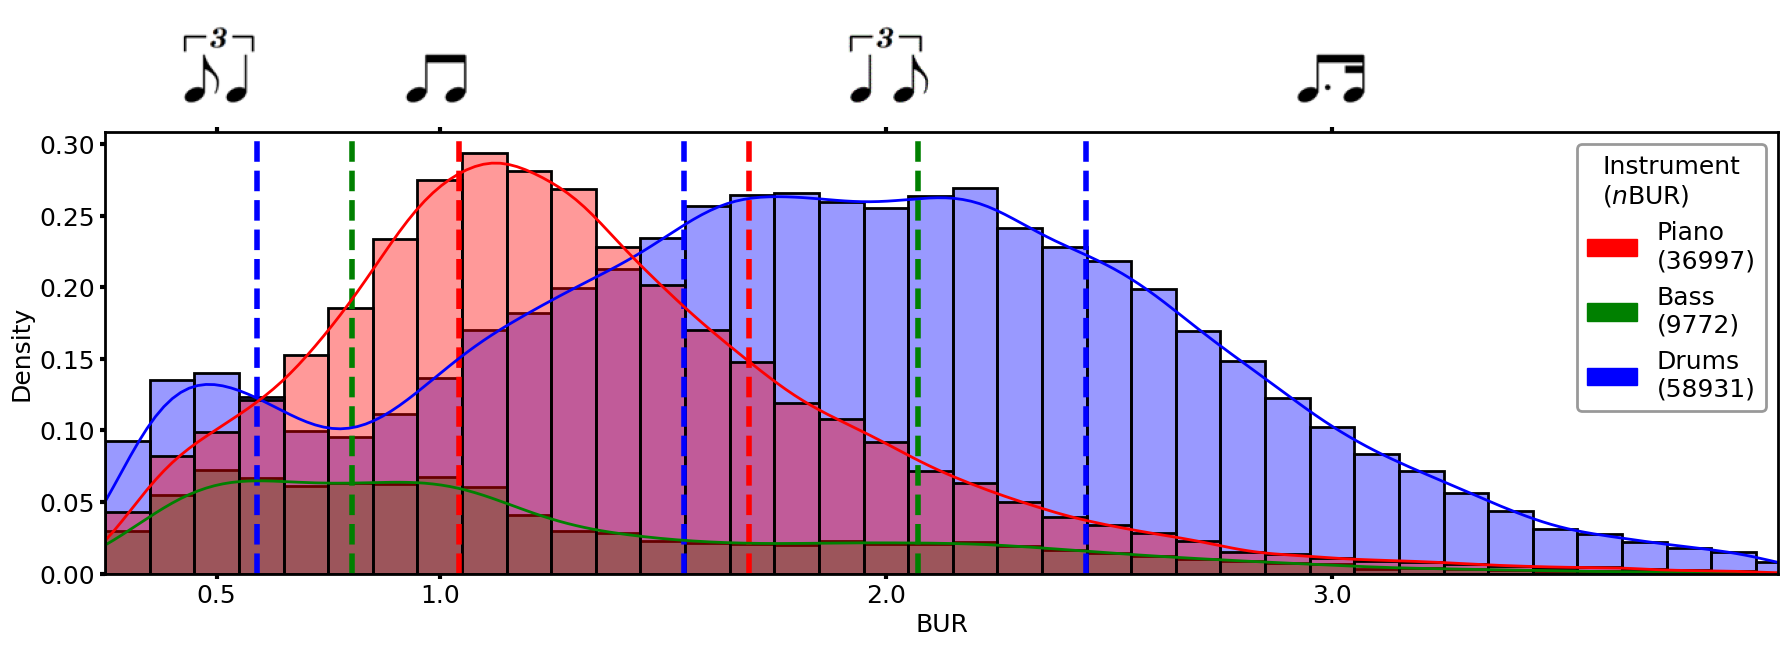

In [173]:
class HistPlotBURByInstrument(vutils.BasePlot):
    BURS_WITH_IMAGES = [0.5, 1, 2, 3]

    def __init__(self, bur_df: pd.DataFrame, gmm_df: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'bur_plots\histplot_bursbyinstrumentgmm_{self.corpus_title}', **kwargs)
        self.bur_df = bur_df
        self.gmm_df = gmm_df
        self.fig, self.ax = plt.subplots(nrows=1, ncols=3, figsize=(vutils.WIDTH, vutils.WIDTH / 3))

    def add_bur_images(self, y):
        """Adds images for required BUR values"""
        # Iterate through all of our BUR values
        for x in self.BURS_WITH_IMAGES:
            # Try and get the image of the notation type for this BUR value
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\bur_notation\bur_{x}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                yield mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False), (x, y),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False
                )

    def _create_plot(self) -> None:
        """Creates the histogram and kde plots"""
        for ax, (idx, grp) in zip(self.ax.flatten())
        self.g = sns.histplot(
            data=self.bur_df, x='bur', stat='density', legend=True, hue='instrument', palette=vutils.RGB,
            bins=vutils.N_BINS, hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), kde=False, multiple='layer',
            binwidth=0.1, lw=vutils.LINEWIDTH, alpha=vutils.ALPHA, zorder=1
        )
        sns.kdeplot(
            data=self.bur_df, x='bur', hue='instrument', lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE,
            palette=vutils.RGB, hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
            clip=(BUR_LOWER, BUR_UPPER), zorder=2
        )
        self._add_gmm_means()

    def _add_gmm_means(self):
        mapping = {i: c for i, c in zip(utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), vutils.RGB)}
        for _, row in self.gmm_df.iterrows():
            self.ax.axvline(row['mean'], ymin=0, ymax=1, color=mapping[row['instr']], alpha=1, lw=vutils.LINEWIDTH * 2, ls='dashed', zorder=1)

    def _format_ticks(self):
        """Formats ticks to add number of BURs"""
        for t in self.ax.get_legend().texts:
            t = t.get_text()
            yield f'{str(t).title()}\n({len(self.bur_df[self.bur_df["instrument"] == t])})'

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Add images for each BUR value we want to plot
        for artist in self.add_bur_images(y=self.ax.get_ylim()[1] + 0.045):
            self.ax.add_artist(artist)
        # Create handles objects because seaborn doesn't create this for us, for some reason...
        handles = [
            mpl.patches.Patch(color=c, label=i) for (c, i) in zip(
                vutils.RGB, utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()
            )
        ]
        # Add the legend in
        leg = self.ax.legend(
            labels=list(self._format_ticks()), handles=handles, title='Instrument\n($n$BUR)', fontsize=vutils.FONTSIZE,
            bbox_to_anchor=(1, 1), frameon=True, ncol=1,  markerscale=vutils.MARKERSCALE
        )
        leg.get_frame().set_linewidth(vutils.LINEWIDTH)
        leg.get_frame().set_edgecolor(vutils.BLACK)
        leg.get_frame().set_alpha(vutils.ALPHA)
        # Set some additional axis properties
        self.ax.set(
            xticks=self.BURS_WITH_IMAGES, xlim=(BUR_LOWER, BUR_UPPER), xlabel='BUR', ylabel='Density',
        )
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.tick_params(axis='both', top=True, bottom=True, labeltop=False, labelbottom=True, width=vutils.TICKWIDTH)
        # self.ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)

    def _format_fig(self) -> None:
        """Formats figure-level properties"""
        self.fig.subplots_adjust(left=0.075, bottom=0.12, right=0.965, top=0.825)

HistPlotBURByInstrument(burs, comp_df).create_plot()
plt.show()

In [178]:
X = burs['bur'].to_numpy().reshape(-1, 1)
# Create the optimized GMM and fit to the data
gm = GaussianMixture(
    random_state=SEED,
    covariance_type='full',
    n_components=2,
    init_params='k-means++'
)
gm.fit(X)
gm.weights_

array([0.43642456, 0.56357544])

In [ ]:

X = burs[burs['instrument'] == 'drums']['bur'].to_numpy().reshape(-1, 1)
kde = KernelDensity(kernel='gaussian').fit(X)
kde.score_samples(X)

In [ ]:
import numpy as np
N = 20
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

In [ ]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
log_dens = kde.score_samples(X_plot)

In [ ]:
import scipy.stats as stats
import scipy.signal as signal

X = burs[burs['instrument'] == 'drums']['bur'].to_numpy().reshape(-1, 1)
X_plot = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
kde = stats.gaussian_kde(X.T)
kde_eval = kde.evaluate(X_plot.T)
peaks = X_plot[signal.find_peaks(kde.evaluate(X_plot.T))[0]]
plt.hist(X, density=True, bins=vutils.N_BINS, color=vutils.BLUE)
plt.plot(X_plot, kde_eval, color=vutils.RED)
plt.vlines(peaks, 0, 0.6, color=vutils.RED)

In [ ]:
peaks

In [ ]:
# Create the optimized GMM and fit to the data
gm = GaussianMixture(
    random_state=SEED,
    covariance_type='full',
    n_components=3,
    means_init=peaks,
)
gm.fit(X)
gm.weights_

In [ ]:
gm.means_